### Heatmap and clustering of NPS reference compounds according to 

Tanimoto coefficient calculated using structural fingerprints
* maccsfp
* MCS
* morganfp
* e3fp

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from scipy import stats
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import r2_score

In [2]:
def tanimoto(fingerprint1, fingerprint2):
    fp1 = int(fingerprint1, 16)
    fp2 = int(fingerprint2, 16)
    fp1_count = bin(fp1).count('1')
    fp2_count = bin(fp2).count('1')
    both_count = bin(fp1 & fp2).count('1')  
    
    if (fp1_count + fp2_count - both_count) != 0:
        return float(both_count)/(fp1_count + fp2_count - both_count)
    else:
        return float(0)

In [6]:
def cluster_metric(X, opt_num_cluster, class_label_true):
    silhouette = silhouette_score(X, opt_num_cluster, metric='euclidean')
    ARI = adjusted_rand_score(class_label_true, opt_num_cluster)
    NMI = adjusted_mutual_info_score(class_label_true, opt_num_cluster)
    print('ARI: %.4f'%ARI,'silhouette: %.4f'%silhouette, 'NMI : %.4f'% NMI)
    #return silhouette, ARI

In [4]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/"

In [5]:
df = pd.read_csv(path+"Drugs Canonical Smiles and Fingerprints - Unique compounds.csv", dtype=object)
print(df.shape)
class_label = df.Class.astype(str).astype(int)
df.head(2)

(127, 14)


,Name,Formula,MW,CAS,PubChem CID,RotBondCount,Conformers,Class,Pharm class,Chem core,Canonical SMILES,maccsfp,morganfp,e3fp
0,Heroin,C21H23NO5,369.4,561-27-3,5462328,4,10,1,Opioids,Alkaloid,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)...,0000000000000000000000000000000000000000000000...,0000000000010001000000000000000001001000000000...,0001000000000010000000000000001000000000000000...
1,Morphine,C17H19NO3,285.34,57-27-2,5288826,0,1,1,Opioids,Alkaloid,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O,0000000000000000000000000000000000000000000000...,0000000000000001000000000000000001001000000000...,0000000000000000000000000000001000000000000000...


In [6]:
df_MCS = pd.read_csv(path+"Drugs pairwise MCS Tanimoto - Unique compounds.csv")

In [7]:
df_MCS.head(2)

,MCSS
0,0.777778
1,0.925926


In [8]:
fingerprints = ['maccsfp','morganfp','e3fp']
df_tani = pd.DataFrame()
for fingerprint in fingerprints:
    tani = []
    print(fingerprint)
    #print(df[fingerprint])
    for i in range(df.shape[0]):
        for j in range(i+1,df.shape[0]):
            tani.append(tanimoto(df.loc[i,str(fingerprint)],df.loc[j,str(fingerprint)]))
    df_tani[str(fingerprint)]=tani
print(df_tani.shape) 

maccsfp
morganfp
e3fp
(8001, 3)


In [9]:
def get_statistics_fp(df,fingerprint):
    print("Fingerprint", fingerprint)
    print("min similarity:", '%.3f' %min(df[fingerprint]),"max similarity:",'%.3f' %max(df[fingerprint]))
    print(fingerprint,"Tc 50 percentile: ", '%.3f' %np.percentile(df[fingerprint], 50))
    print(fingerprint,"Tc 90 percentile: ", '%.3f' %np.percentile(df[fingerprint], 90))
    print("Standard deviation", '%.3f' %np.std(df[fingerprint]))
    print("Mean Tc", '%.3f' %np.mean(df[fingerprint]))
    print("*"*10)

In [10]:
get_statistics_fp(df_tani,'maccsfp')
get_statistics_fp(df_MCS,'MCSS')
get_statistics_fp(df_tani,'morganfp')
get_statistics_fp(df_tani,'e3fp')

Fingerprint maccsfp
min similarity: 0.111 max similarity: 1.000
maccsfp Tc 50 percentile:  0.353
maccsfp Tc 90 percentile:  0.591
Standard deviation 0.154
Mean Tc 0.384
**********
Fingerprint MCSS
min similarity: 0.125 max similarity: 1.000
MCSS Tc 50 percentile:  0.333
MCSS Tc 90 percentile:  0.667
Standard deviation 0.184
Mean Tc 0.388
**********
Fingerprint morganfp
min similarity: 0.025 max similarity: 1.000
morganfp Tc 50 percentile:  0.133
morganfp Tc 90 percentile:  0.298
Standard deviation 0.123
Mean Tc 0.170
**********
Fingerprint e3fp
min similarity: 0.024 max similarity: 0.696
e3fp Tc 50 percentile:  0.110
e3fp Tc 90 percentile:  0.220
Standard deviation 0.076
Mean Tc 0.132
**********


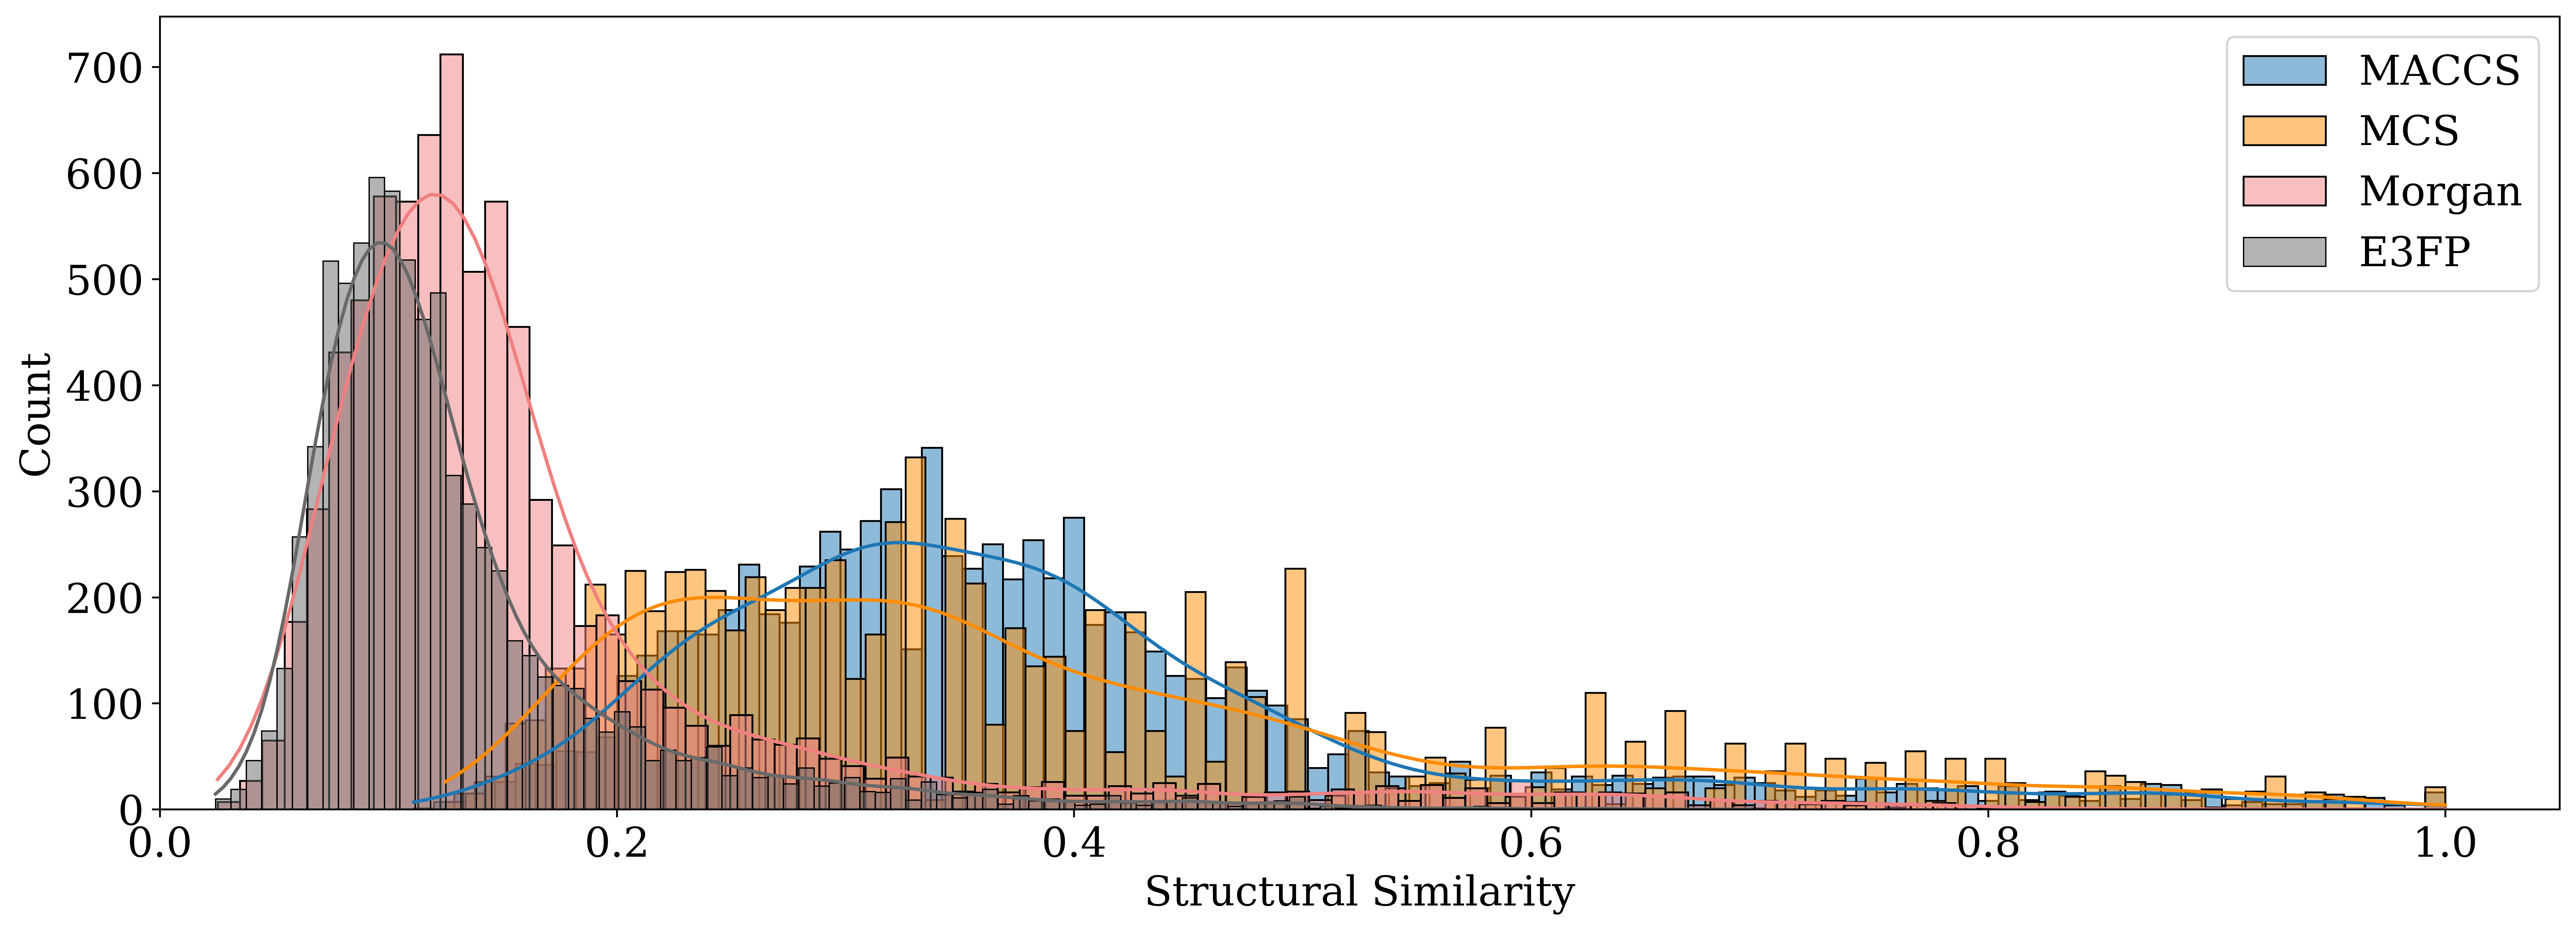

In [21]:
fig = plt.figure(figsize=(16,6), dpi = 600)
plt.rc('font', family='serif', size = 18)
sns.histplot(df_tani['maccsfp'], label = "MACCS" ,  kde=True,bins=100)
sns.histplot(df_MCS['MCSS'], label = "MCS" , kde=True,  color="darkorange",bins=100)
sns.histplot(df_tani['morganfp'], label = "Morgan" , kde=True,  color="lightcoral",bins=100)
sns.histplot(df_tani['e3fp'], label = "E3FP" ,  kde=True, color="dimgrey",bins=100)
plt.xlabel('Structural Similarity')
plt.xlim(0, 1.05)
legend = plt.legend(loc='upper right', shadow=False, fontsize=18)
fig.tight_layout()
plt.show()
fig.savefig(path+"Figure. Structral similarity histogram of Drug compounds.png",  bbox_inches='tight')

In [56]:
list_len = df.shape[0]
test_cid_1 = list(df['Name'])
test_cid_1 = test_cid_1[0:list_len]
test_cid_2 = test_cid_1

In [57]:
fingerprint = "e3fp"

In [58]:
df_cid = pd.DataFrame(0,index=test_cid_1,columns=test_cid_2)

df_pair = pd.DataFrame(0,index=test_cid_1,columns=['Pair','MaxValue'])

In [59]:
for i,cid_1 in enumerate(test_cid_1):
    #print(i)
    if i%40 == 0:
        print(i*100/df.shape[0],'%')
    for j,cid_2 in enumerate(test_cid_2):
        #print(j)
        df_cid.loc[cid_1,cid_2] = tanimoto(df.loc[i,fingerprint], df.loc[j,fingerprint])
    #tmpInd = df_cid.loc[cid_1,df_cid.loc[cid_1,:]!=1].idxmax()
    tmpInd = df_cid.loc[cid_1,cid_1 != df_cid.columns].idxmax()
    tmpValue = df_cid.loc[cid_1,tmpInd]
    df_pair.loc[cid_1,'Pair'] = tmpInd
    df_pair.loc[cid_1,'MaxValue'] = tmpValue
    
df_pair = df_pair.reset_index()

0.0 %
31.496062992125985 %
62.99212598425197 %
94.48818897637796 %


In [60]:
df_cid.to_csv(path+"Drugs E3FP Tanimoto matrix - Unique compounds.csv")
df_pair.to_csv(path+"Drugs E3FP Tanimoto nearest neighbor - Unique compounds.csv")

In [61]:
df_cid = pd.read_csv(path+"Drugs E3FP Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")
#df_cid

In [62]:
X = df_cid.values

In [63]:
Z_1 = linkage(X, method='ward')
Pdist = pdist(X)
c, coph_dists = cophenet(Z_1, Pdist)
print(c)

0.7673813819973992


In [64]:
silhouette,n_clu = list(),list()
for num_cluster in range(2, 50):
    cluster_nodes= fcluster(Z_1,num_cluster,criterion='maxclust')
    score = silhouette_score(X, cluster_nodes, metric='euclidean')
    silhouette.append(score)
    n_clu.append(num_cluster)
print("maximum average silhouette score: %0.4f" % max(silhouette))

maximum average silhouette score: 0.2071


In [65]:
result = zip(n_clu,silhouette)
zipped_result = list(result)
df_result = pd.DataFrame(zipped_result,columns=['n_clusters','average_silouette'])

In [66]:
# optimal K with MACCS Tc
df_result[df_result['average_silouette']==max(silhouette)]

,n_clusters,average_silouette
0,2,0.207109


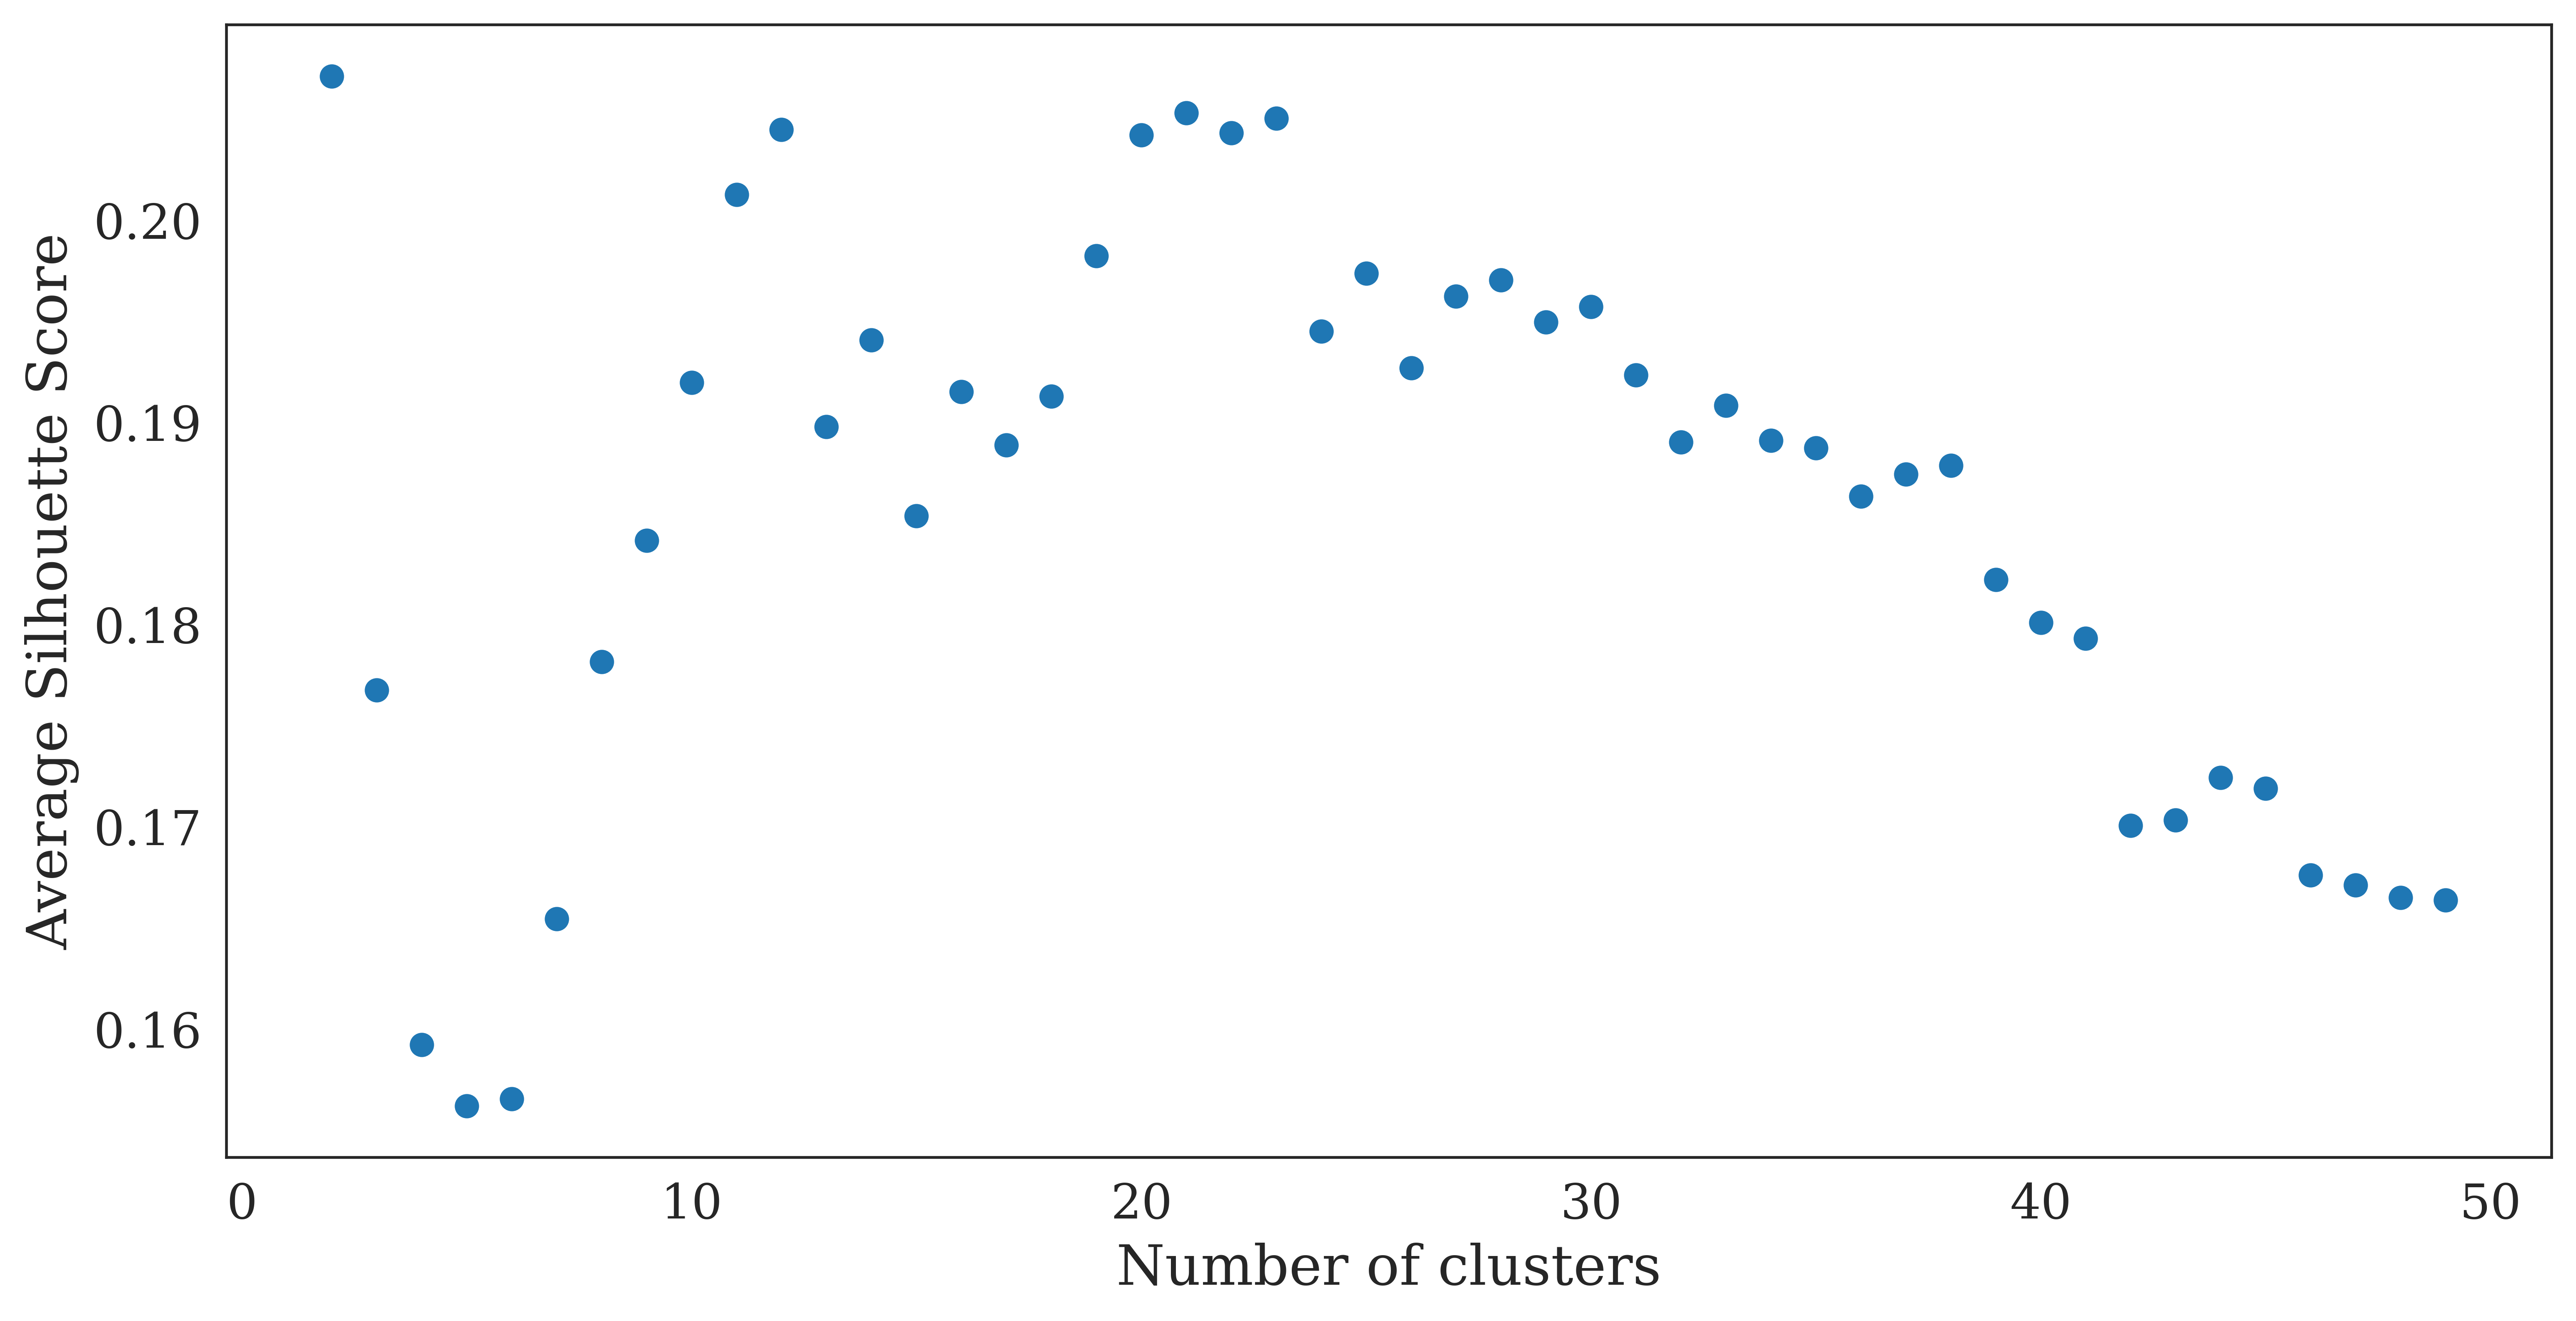

In [67]:
fig = plt.figure(figsize=(12,6), dpi = 600)
plt.rc('font', family='serif')
plt.scatter(n_clu,silhouette)
plt.xlabel("Number of clusters", fontsize=16)
plt.ylabel("Average Silhouette Score", fontsize=16)
#plt.title("Silhouette analysis to determine optimal number of hierarchical clusters with MACCS similarity", fontsize=13)
#plt.legend(loc='best')
plt.show()

fig.savefig(path+"Figure. Silhouette analysis for determining optimal clusters K using E3FP matrix.png", bbox_inches='tight')

In [72]:
#distance cutoff
t = np.arange(0.5, 5,0.05)

silhouette= list()
for i in range(len(t)):
    #print(t[i])
    #Getting cluster labels
    cluster_nodes= fcluster(Z_1,t[i],criterion='distance')
    
    #Calculate average silhouette score
    score = silhouette_score(X, cluster_nodes, metric='euclidean')
    
    silhouette.append(score)

print("maximum average silhouette score: %0.4f" % max(silhouette))

maximum average silhouette score: 0.2053


In [73]:
result = zip(t,silhouette)
zipped_result = list(result)
df_result = pd.DataFrame(zipped_result,columns=['t_cutoff','average_silouette'])

df_result[df_result['average_silouette']==max(silhouette)]

,t_cutoff,average_silouette
24,1.7,0.2053


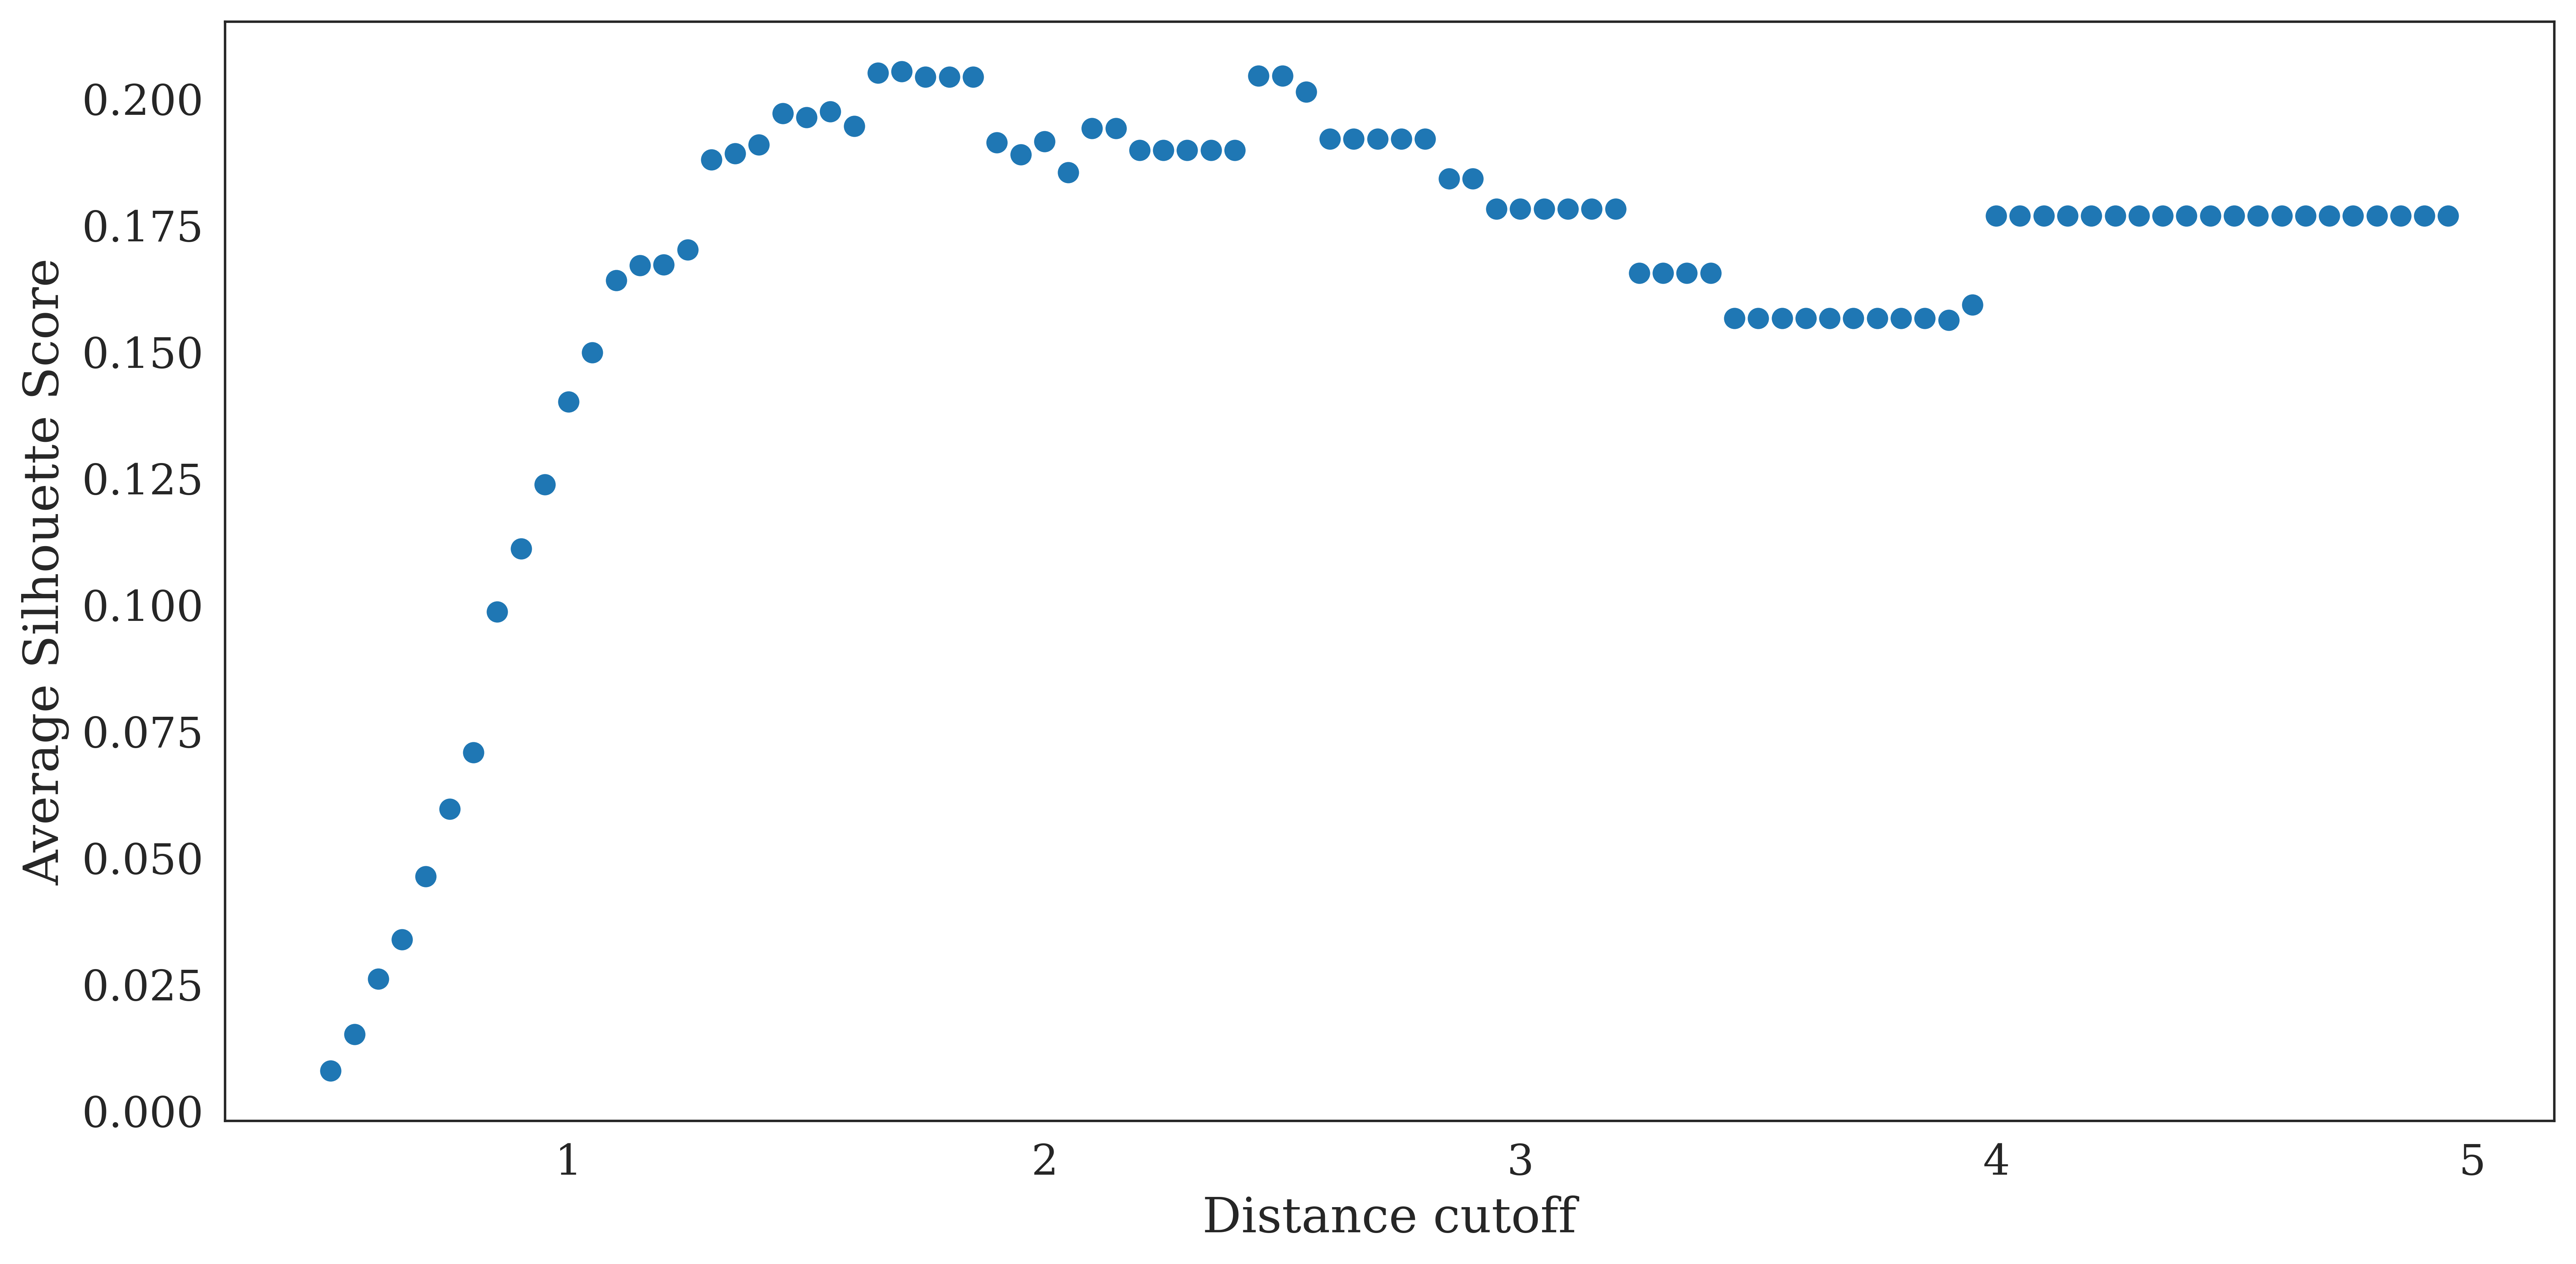

In [74]:
fig = plt.figure(figsize=(12,6), dpi = 600)
plt.rc('font', family='serif')
plt.scatter(t,silhouette)

plt.xlabel("Distance cutoff", fontsize=16)
plt.ylabel("Average Silhouette Score", fontsize=16)
#plt.title("Silhouette analysis to determine optimal number of hierarchical clusters with MACCS similarity matrices", fontsize=13)
#plt.legend(loc='best')
fig.tight_layout()
plt.show()

fig.savefig(path+"Figure. Silhouette analysis for determining optimal clusters K using E3FP matrix with distance cutoff.png"
           , bbox_inches='tight')

In [75]:
cluster_nodes= fcluster(Z_1,1.7,criterion='distance')
print("Optimal K with distance cutoff using PF", max(cluster_nodes))

Optimal K with distance cutoff using PF 21


In [76]:
yticklabels= df_cid.index

/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 7200x7200 with 0 Axes>

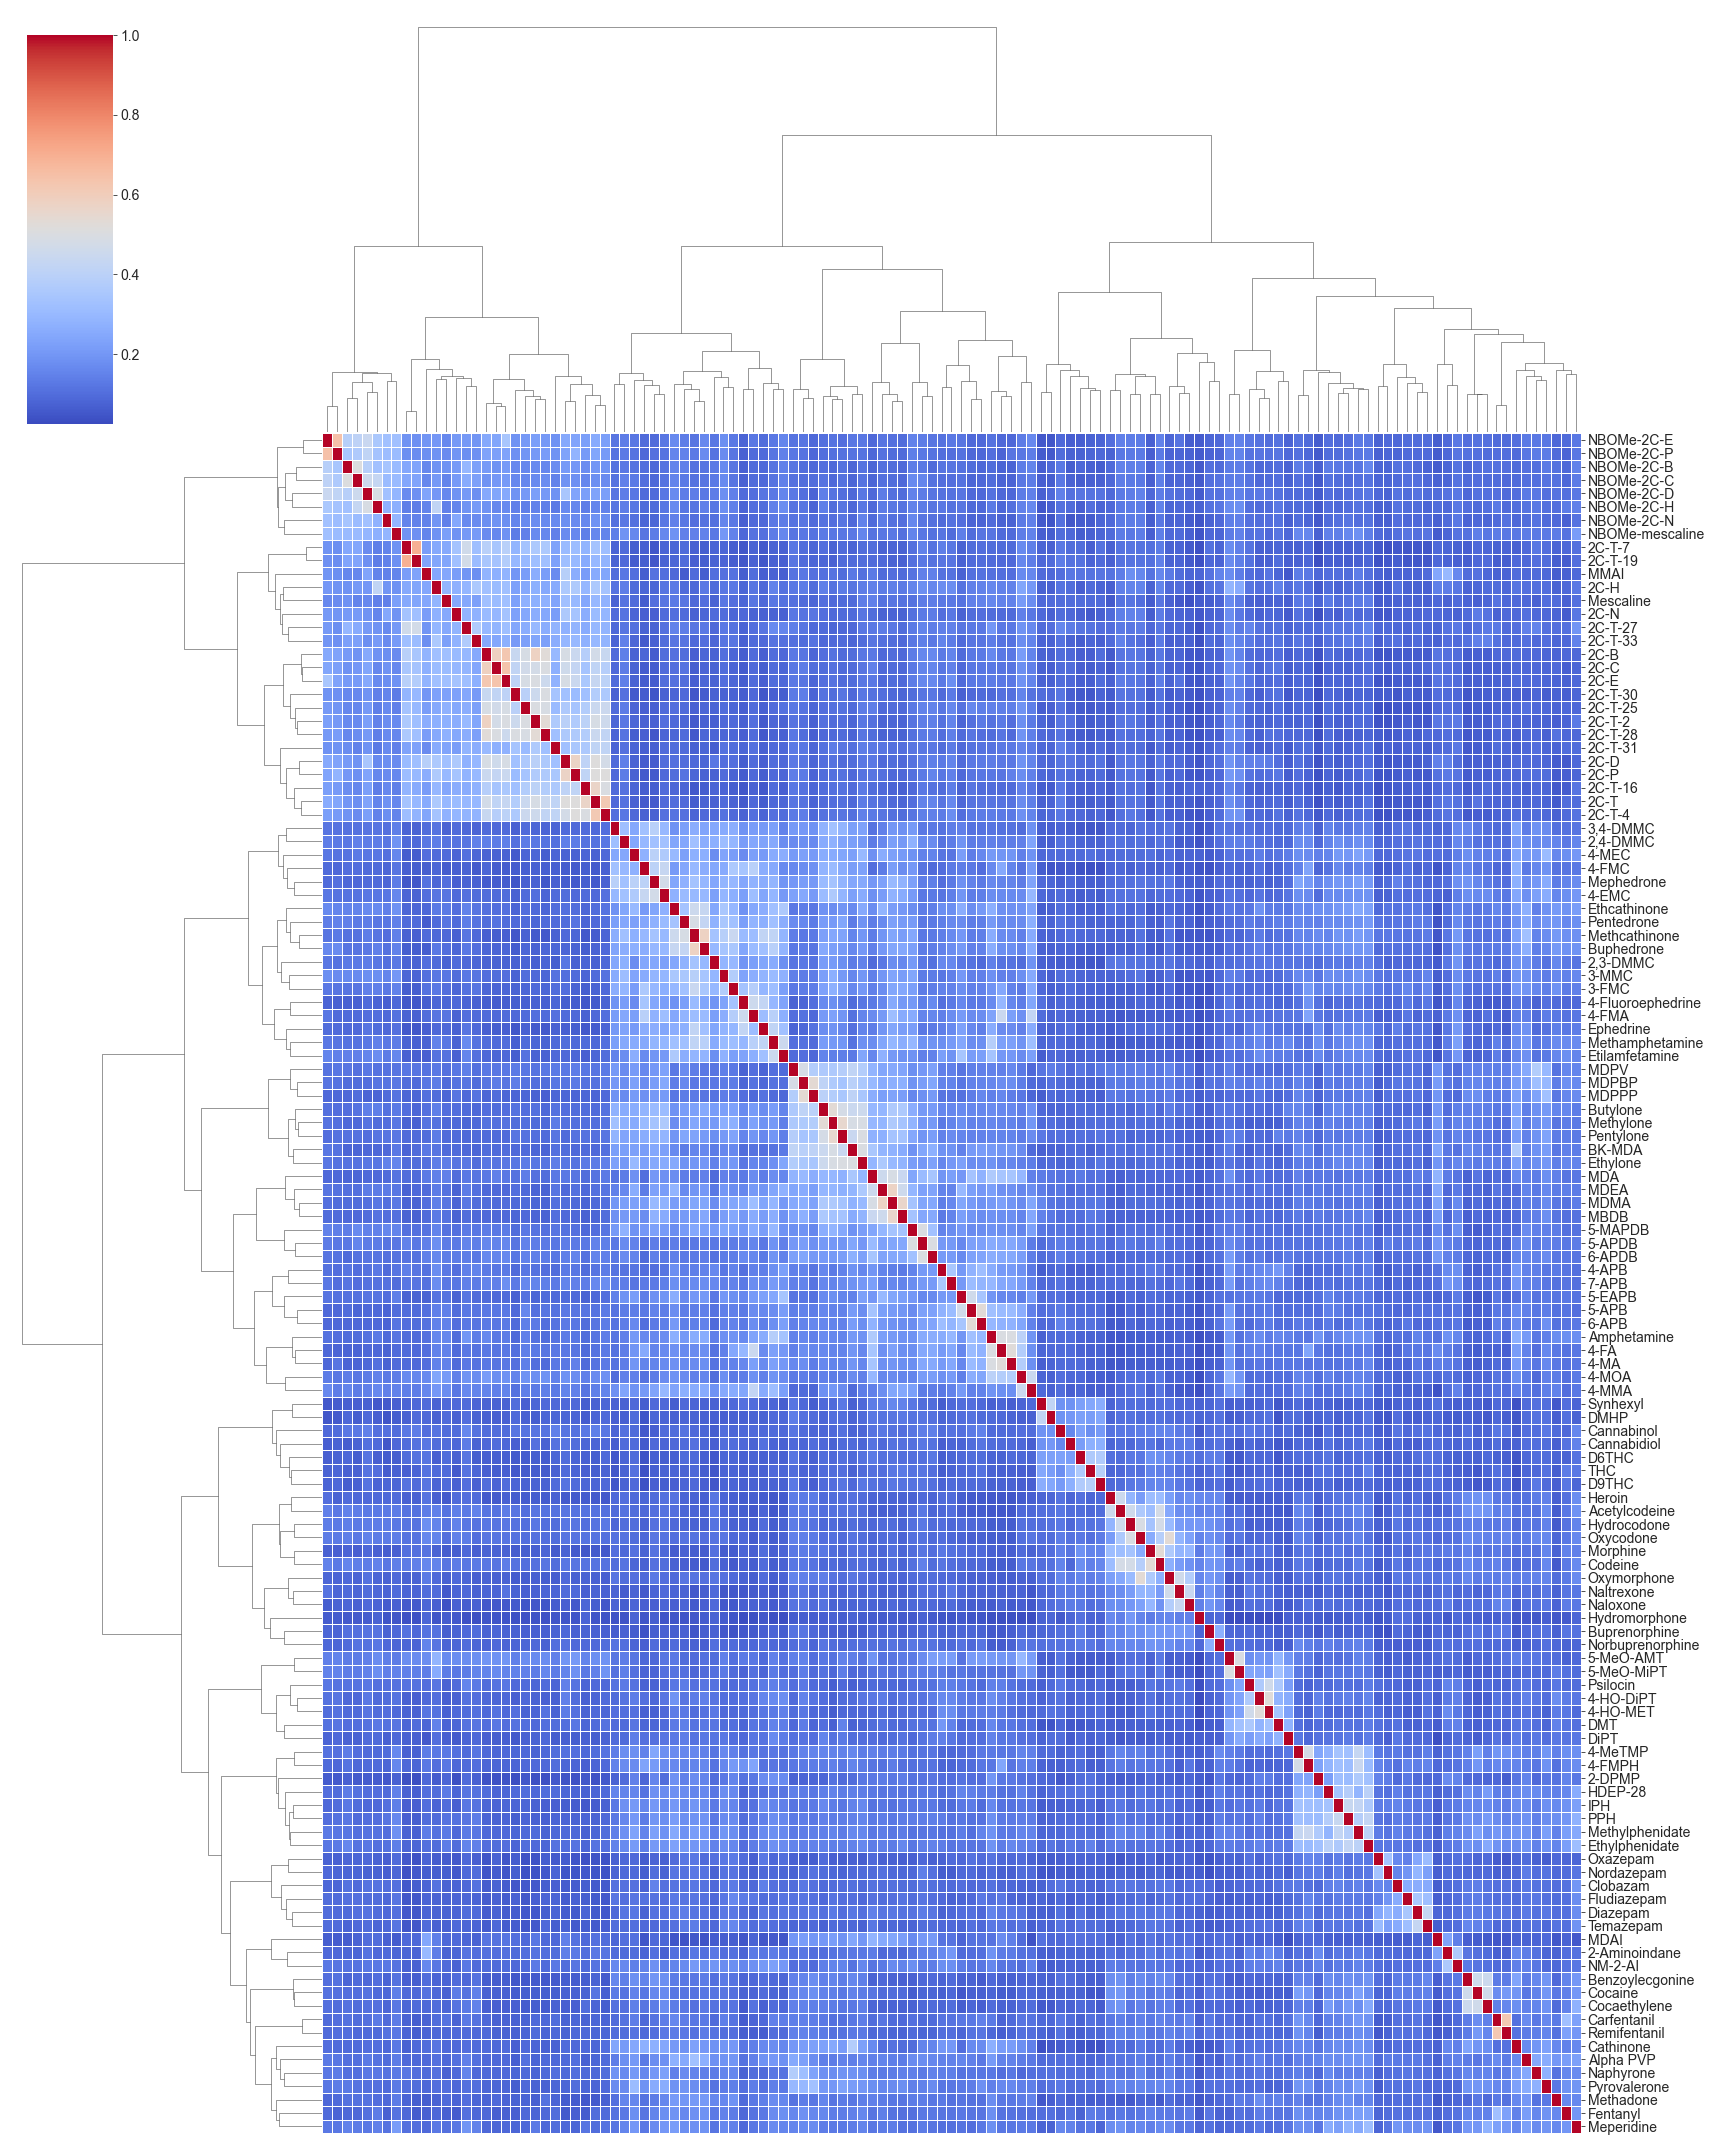

In [77]:
fig = plt.figure(figsize=(12,12), dpi = 600)
plt.rc('font', family='serif', size = 14)
sns.set_style('white')
fig = sns.clustermap(X, method='ward',cmap='coolwarm',fmt='d', linewidth=.5, xticklabels=False, yticklabels=yticklabels,figsize=(24,30))
plt.show()
fig.savefig(path+"Figure. Heatmap of the E3FP clustering of Drug compounds.png", dpi=600,bbox_inches='tight')

In [78]:
cluster_nodes = fcluster(Z_1,21,criterion='maxclust')

In [79]:
(unique, counts) = np.unique(cluster_nodes, return_counts=True)
print("Number of clusters:", unique.max())

Number of clusters: 21


In [80]:
df_result = pd.read_csv(path+"Drugs Canonical Smiles and Fingerprints and optimal K - Unique compounds.csv")

In [81]:
df_result['E3FP_K'] = pd.Series(cluster_nodes, index=df.index)

In [82]:
df_result.head()

,Name,Formula,MW,CAS,PubChem CID,RotBondCount,Conformers,Class,Pharm class,Chem core,Canonical SMILES,maccsfp,MACCS_K,MCS_K,Pearson_K,Spearman_K,Morgan_K,E3FP_K
0,Heroin,C21H23NO5,369.40,561-27-3,5462328,4,10,1,Opioids,Alkaloid,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)...,0000000000000000000000000000000000000000000000...,14,9,11,7,4,12
1,Morphine,C17H19NO3,285.34,57-27-2,5288826,0,1,1,Opioids,Alkaloid,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O,0000000000000000000000000000000000000000000000...,14,9,3,13,4,12
2,Acetylcodeine,C20H23NO4,341.40,6703-27-1,5486550,3,3,1,Opioids,Alkaloid,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC)CCN3C,0000000000000000000000000000000000000000000000...,14,9,11,7,4,12
3,Codeine,C18H21NO3,299.40,76-57-3,5284371,1,1,1,Opioids,Alkaloid,CN1CCC23C4C1CC5=C2C(=C(C=C5)OC)OC3C(C=C4)O,0000000000000000000000000000000000000000000000...,14,9,3,13,4,12
4,Hydrocodone,C18H21NO3,299.40,125-29-1,5284569,1,1,1,Opioids,Alkaloid,CN1CCC23C4C1CC5=C2C(=C(C=C5)OC)OC3C(=O)CC4,0000000000000000000000000000000000000000000000...,14,9,11,7,5,12


In [83]:
df_result.to_csv(path+'Drugs Canonical Smiles and Fingerprints and optimal K - Unique compounds.csv',index=False)

### ARI compare to "true class label"

* Internal: Silhoutee
* External: Jaccard, ARI

In [19]:
df = pd.read_csv(path+"Drugs Canonical Smiles and Fingerprints and optimal K - Unique compounds.csv", dtype=object)
MACCS_cid = pd.read_csv(path+"Drugs MACCS Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")
X_MACCS = MACCS_cid.values
MCS_cid = pd.read_csv(path+"Drugs MCS Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")
X_MCS = MCS_cid.values
print(df.shape)
class_label = df.Class.astype(str).astype(int)
df.head(2)

(127, 20)


,Name,Formula,MW,CAS,PubChem CID,RotBondCount,Conformers,Class,Pharm class,Chem core,Canonical SMILES,maccsfp,MACCS_K,MCS_K,Pearson_K,Spearman_K,Morgan_K,E3FP_K,Spearman_total_IR_K,Pearson_total_IR_K
0,Heroin,C21H23NO5,369.4,561-27-3,5462328,4,10,1,Opioids,Alkaloid,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)...,0000000000000000000000000000000000000000000000...,14,9,11,7,4,12,13,8
1,Morphine,C17H19NO3,285.34,57-27-2,5288826,0,1,1,Opioids,Alkaloid,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O,0000000000000000000000000000000000000000000000...,14,9,3,13,4,12,8,2


In [8]:
Morgan_cid = pd.read_csv(path+"Drugs Morgan Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")
X_Morgan = Morgan_cid.values
E3FP_cid = pd.read_csv(path+"Drugs E3FP Tanimoto matrix - Unique compounds.csv",index_col="Unnamed: 0")
X_E3FP = E3FP_cid.values

In [9]:
cluster_metric(X_MACCS, df.MACCS_K, df.Class)
cluster_metric(X_MCS, df.MCS_K, df.Class)

ARI: 0.7402 silhouette: 0.4945 NMI : 0.8384
ARI: 0.8120 silhouette: 0.5799 NMI : 0.9129


In [10]:
cluster_metric(X_Morgan, df.Morgan_K, df.Class)
cluster_metric(X_E3FP, df.E3FP_K, df.Class)

ARI: 0.7223 silhouette: 0.4084 NMI : 0.8481
ARI: 0.5933 silhouette: 0.2053 NMI : 0.7701


In [11]:
Pearson_cid = pd.read_csv(path+"Drug DFT IR spectra Pearson matrix - low variance Unique compounds.csv",index_col="Unnamed: 0")
X_Pearson = Pearson_cid.values
Spearman_cid = pd.read_csv(path+"Drug DFT IR spectra Spearman matrix - low variance Unique compounds.csv",index_col="Unnamed: 0")
X_Spearman = Spearman_cid.values

In [13]:
Spearman_cid

,Heroin,Morphine,Acetylcodeine,Codeine,Hydrocodone,Oxycodone,Hydromorphone,Oxymorphone,Naltrexone,Naloxone,...,2C-T-30,2C-T-31,2C-T-33,Psilocin,DMT,DiPT,4-HO-DiPT,4-HO-MET,5-MeO-AMT,5-MeO-MiPT
Heroin,1.000000,0.673858,0.947232,0.709903,0.915433,0.890532,0.823451,0.812949,0.780869,0.720229,...,0.763271,0.802687,0.771226,0.493966,0.476274,0.538736,0.505635,0.458545,0.623394,0.679639
Morphine,0.673858,1.000000,0.740646,0.902731,0.716356,0.775392,0.823661,0.828135,0.791400,0.679906,...,0.773154,0.787940,0.757911,0.595570,0.601058,0.666228,0.751606,0.718514,0.710681,0.774057
Acetylcodeine,0.947232,0.740646,1.000000,0.806895,0.962937,0.932124,0.839482,0.825147,0.800496,0.721803,...,0.831741,0.864971,0.850690,0.636827,0.559029,0.619359,0.603381,0.576898,0.724870,0.780755
Codeine,0.709903,0.902731,0.806895,1.000000,0.785955,0.797232,0.741975,0.748412,0.714764,0.601430,...,0.834689,0.851937,0.823151,0.716682,0.691977,0.748416,0.738113,0.713900,0.797908,0.861399
Hydrocodone,0.915433,0.716356,0.962937,0.785955,1.000000,0.960351,0.872487,0.847001,0.802729,0.712928,...,0.806782,0.839293,0.828768,0.625293,0.537997,0.586519,0.574065,0.555391,0.711698,0.772682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DiPT,0.538736,0.666228,0.619359,0.748416,0.586519,0.560919,0.471028,0.472598,0.493093,0.503355,...,0.741103,0.702614,0.705917,0.819817,0.903150,1.000000,0.778326,0.765455,0.759764,0.844194
4-HO-DiPT,0.505635,0.751606,0.603381,0.738113,0.574065,0.581372,0.581347,0.559850,0.625880,0.646158,...,0.705467,0.713937,0.743440,0.768006,0.690650,0.778326,1.000000,0.864324,0.779743,0.820273
4-HO-MET,0.458545,0.718514,0.576898,0.713900,0.555391,0.587349,0.546877,0.558964,0.472858,0.467082,...,0.627503,0.640635,0.685028,0.799485,0.811466,0.765455,0.864324,1.000000,0.713341,0.809486
5-MeO-AMT,0.623394,0.710681,0.724870,0.797908,0.711698,0.645343,0.600906,0.567854,0.608665,0.634229,...,0.833325,0.845227,0.855061,0.780908,0.719488,0.759764,0.779743,0.713341,1.000000,0.924088


In [12]:
cluster_metric(X_Pearson, df.Pearson_K, df.Class)
cluster_metric(X_Spearman, df.Spearman_K, df.Class)

ARI: 0.3640 silhouette: 0.3586 NMI : 0.5102
ARI: 0.3159 silhouette: 0.3668 NMI : 0.5158


In [18]:
Pearson_totalIR_cid = pd.read_csv(path+"Drug DFT total IR spectra Pearson matrix - low variance Unique compounds.csv",index_col="Unnamed: 0")
X_Pearson_totalIR = Pearson_totalIR_cid.values
Spearman_totalIR_cid = pd.read_csv(path+"Drug DFT total IR spectra Spearman matrix - low variance Unique compounds.csv",index_col="Unnamed: 0")
X_Spearman_totalIR = Spearman_totalIR_cid.values

In [20]:
cluster_metric(X_Pearson_totalIR, df.Pearson_total_IR_K, df.Class)
cluster_metric(X_Spearman_totalIR, df.Spearman_total_IR_K, df.Class)

ARI: 0.3893 silhouette: 0.3695 NMI : 0.5249
ARI: 0.4088 silhouette: 0.3528 NMI : 0.5590
